# Preprocessing using Scanpy

Following the Scanpy tutorial https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html and partly this workshop: https://chanzuckerberg.github.io/scRNA-python-workshop/preprocessing/01-basic-qc.html

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap
import seaborn as sb
from matplotlib import colors

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(6, 4))
sc.settings.verbosity = 3

np.random.seed(2211)

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


Load data into a pandas Dataframe and convert into an AnnData object:

In [2]:
dataset = 'E13_hom'
data = pd.read_csv('../data/' + dataset + '.csv', index_col=0)

In [3]:
adata = sc.AnnData(X=data.T)
print(adata)

AnnData object with n_obs × n_vars = 6333 × 30213


## Quality Control

Show the genes that yield the highest fraction of counts in each single cells, across all cells. For each gene, it computes the fraction of counts assigned to that gene within a cell. The n_top genes with the highest mean fraction over all cells are plotted as boxplots.

normalizing counts per cell
    finished (0:00:00)


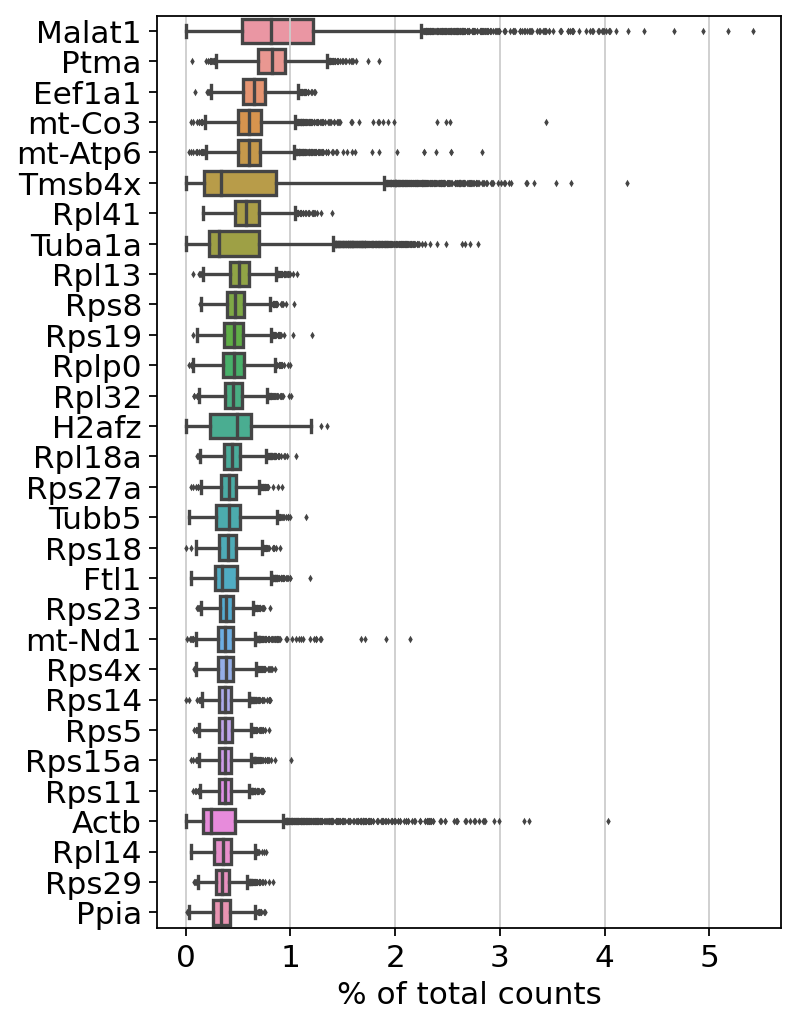

In [4]:
sc.pl.highest_expr_genes(adata)

### Basic filltering

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13976 genes that are detected in less than 3 cells


### Mitochondrial genes

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)  # compute QC metrics

In [7]:
adata

AnnData object with n_obs × n_vars = 6333 × 16237
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Plot QC measures - violin plots

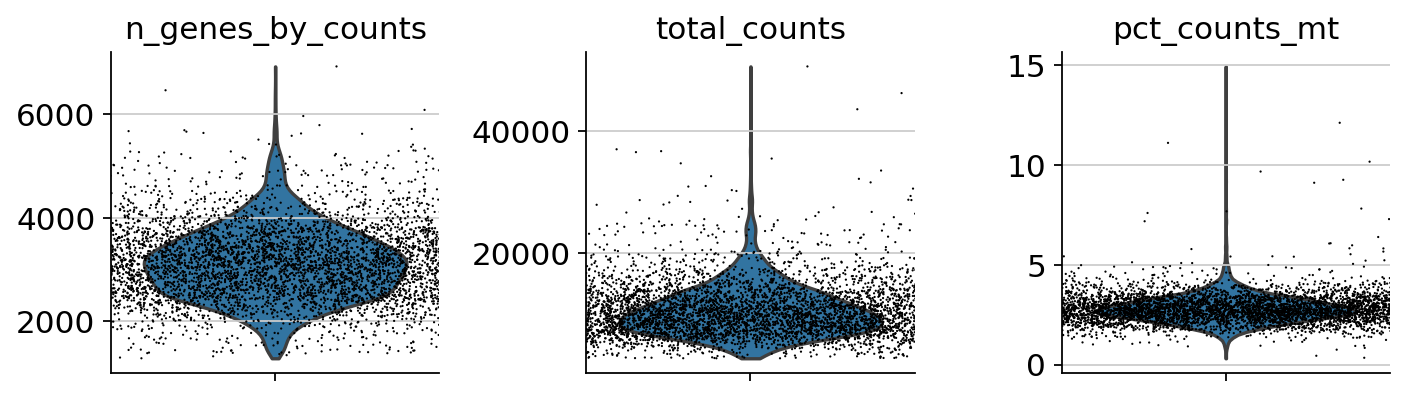

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.7, multi_panel=True)

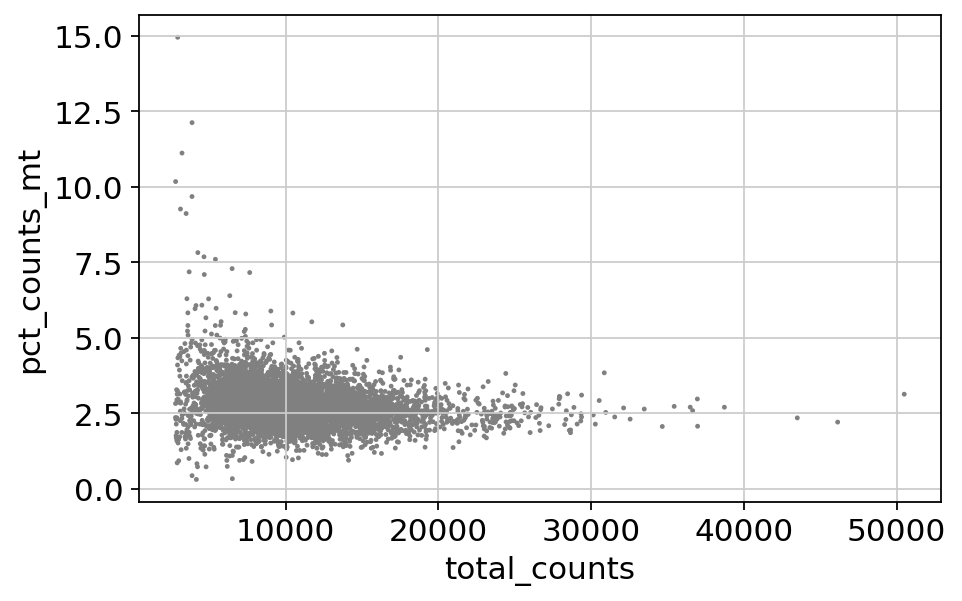

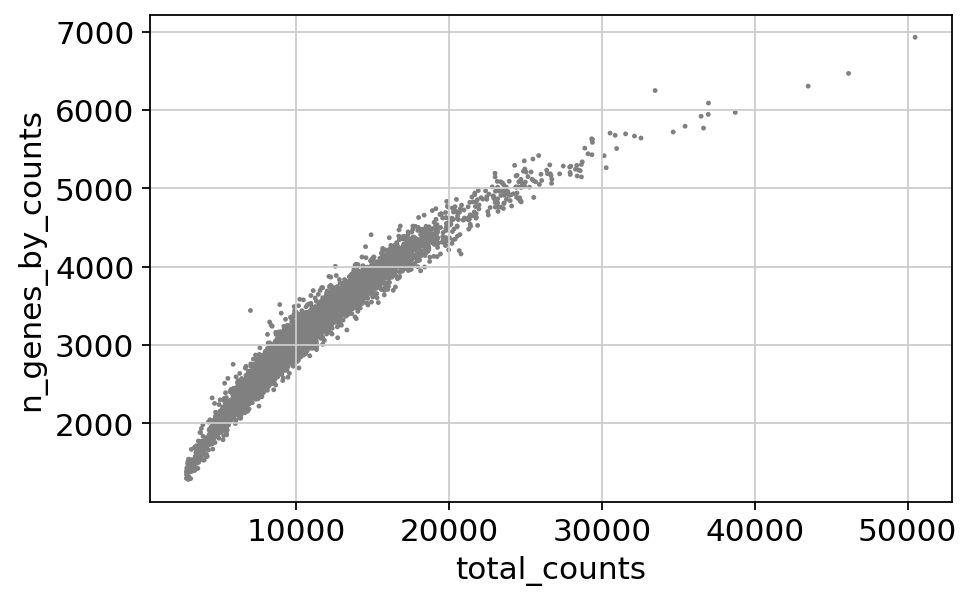

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Remove cells that have too many mitochondrial genes expressed or too many total counts.

In [10]:
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.n_genes_by_counts < (7500 if 'E14' in dataset else 6000), :]  # for E14: 7500, for E13: 6000
adata = adata[adata.obs.pct_counts_mt < (10 if 'E14' in dataset else 5), :]  # for E14: 10, for E13: 5
print(adata)

View of AnnData object with n_obs × n_vars = 6285 × 16237
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [11]:
raw_counts = adata.copy()
raw_counts

AnnData object with n_obs × n_vars = 6285 × 16237
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
# Transpose and write to csv for cellassign

# df = pd.DataFrame(adata.X.transpose())
# df.index = adata.var_names
# df.columns = adata.obs_names
# df.to_csv('../ann_data/' + dataset + '_qc.csv')

In [13]:
# sc.pp.recipe_seurat(adata, plot=True)

## Normalization

Total-count normalize (library-size correct) the data matrix **X** to 40,000 genes per cell, so that counts become comparable among cells. Then, logarithmize the data.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4, key_added='size_factors')
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/home/pts/dissertation_single_cell/.env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Filter using the highly variable genes.

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


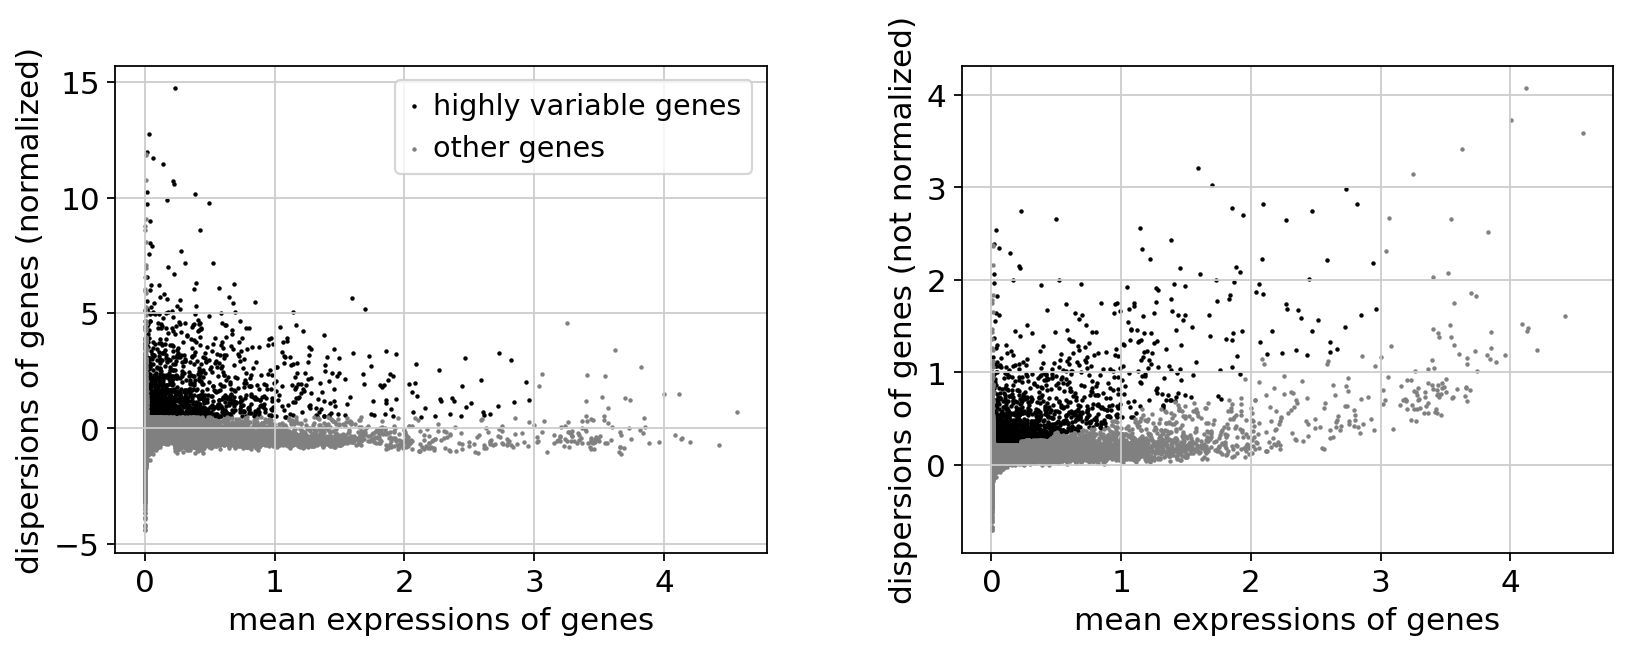

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [14]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/home/pts/dissertation_single_cell/.env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
# Initialise adata.raw
adata.raw = raw_counts[:, list(adata.var_names)]
print(adata.X.shape)
print(adata.raw.X.shape)

(6285, 1722)
(6285, 1722)


## Principal Component Analysis

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


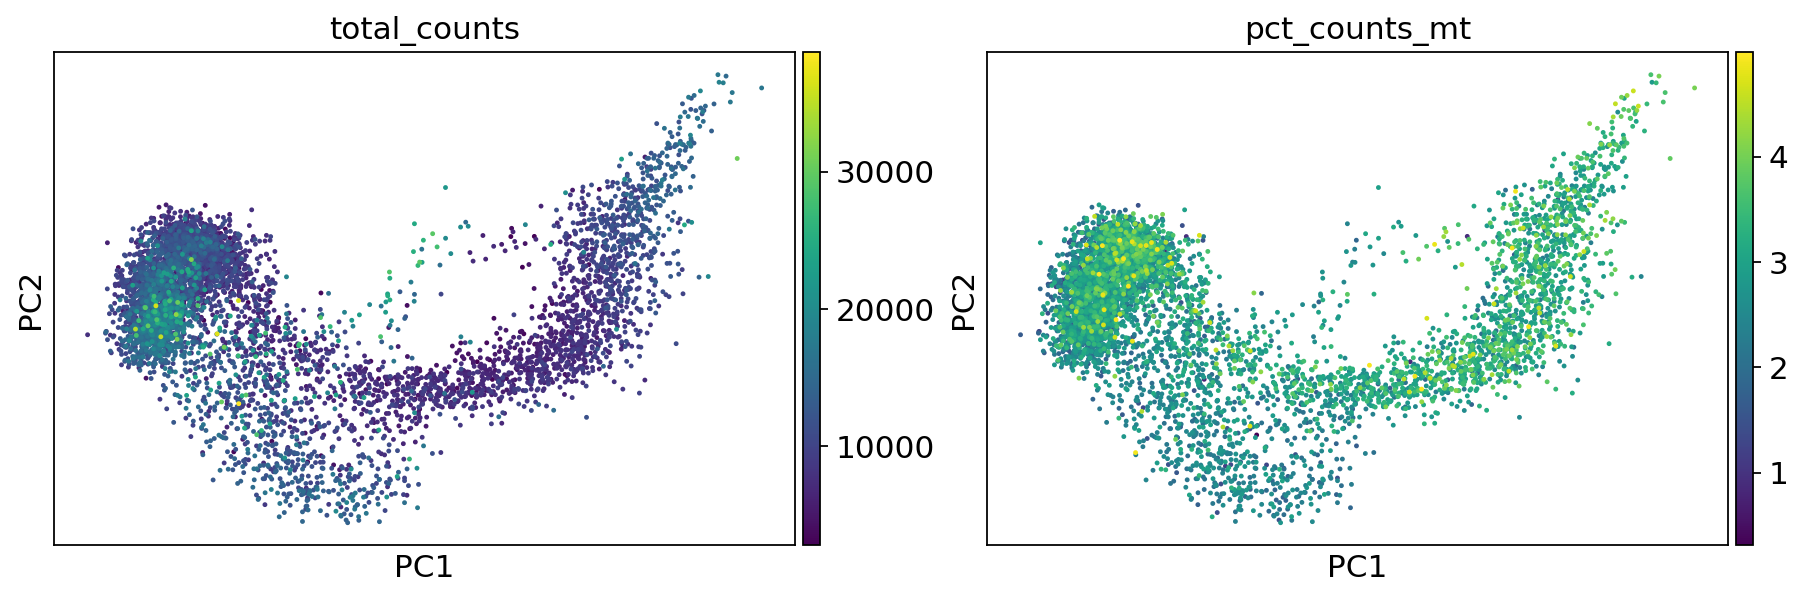

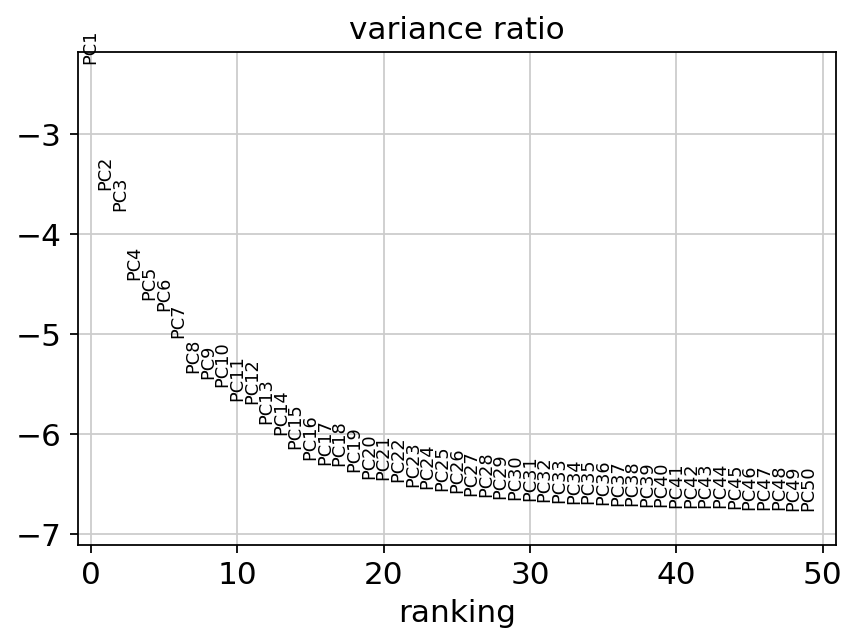

In [16]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color=['total_counts', 'pct_counts_mt'])
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## Cell Cycle Scoring and Regression

### Check cell cycle effect on the dataset

1. PCA on 50 PCs
2. UMAP on 40 PCs (from the elbow plot above)
3. UMAP on the whole X

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    497 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    450 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'phase' as categorical


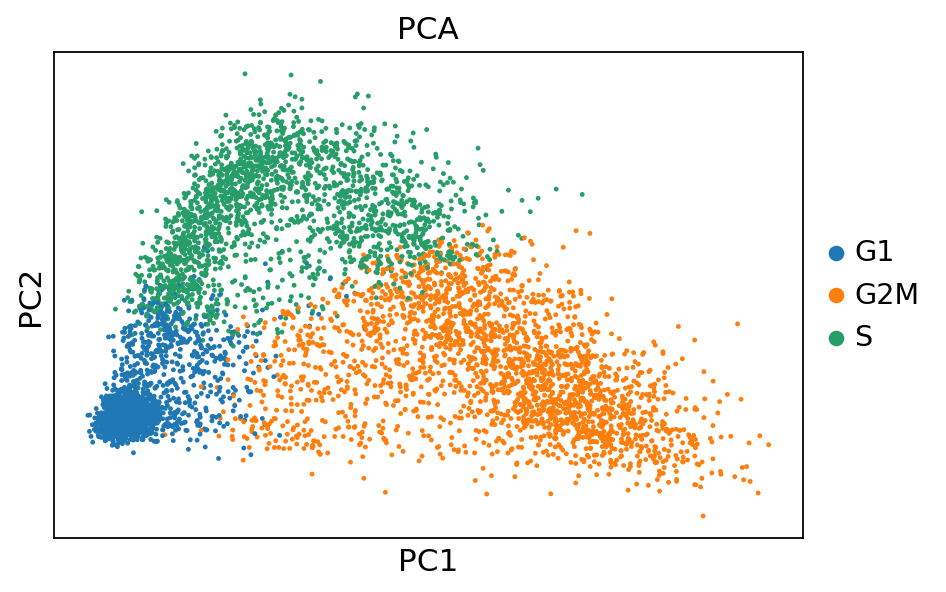

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


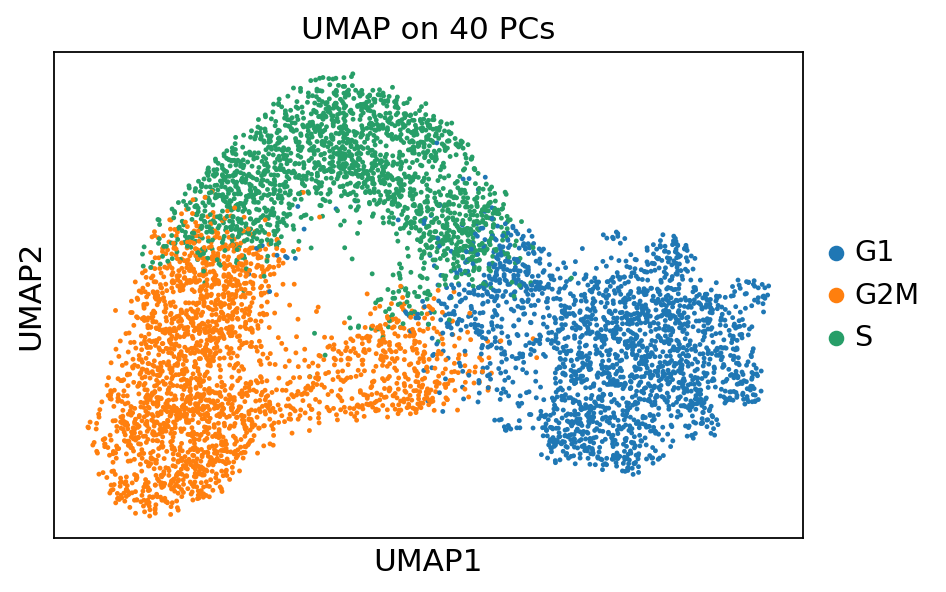

In [17]:
# Load cell cycle genes from file and split into S and G2M genes
cell_cycle_genes = [x.strip().lower().capitalize() for x in open('../preprocessing/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

# Perform cell cycle scoring
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
cc_phase = adata.obs.phase
adata_cc_genes = adata[:, cell_cycle_genes]  # Subset of the data using only the cell cycle phase genes

# PCA
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', title='PCA')

# UMAP on 40 PCs
sc.pp.neighbors(adata_cc_genes, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_cc_genes)
sc.pl.umap(adata_cc_genes, color='phase', title='UMAP on 40 PCs')

### Regress out S score and G2M score

In [18]:
sc.pp.regress_out(adata, ['pct_counts_mt', 'S_score', 'G2M_score'])
sc.pp.scale(adata, max_value=10)

regressing out ['pct_counts_mt', 'S_score', 'G2M_score']


... storing 'phase' as categorical


    finished (0:00:07)


### Reproject dataset using the cell cycle genes to check that the cell cycle effect is now not present.

After regressing out the cell cycle
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


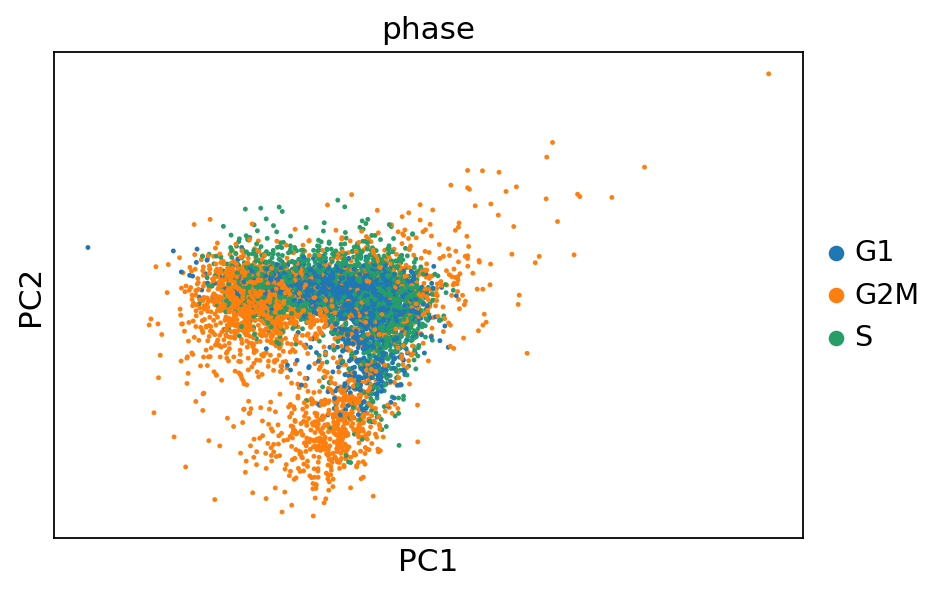

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


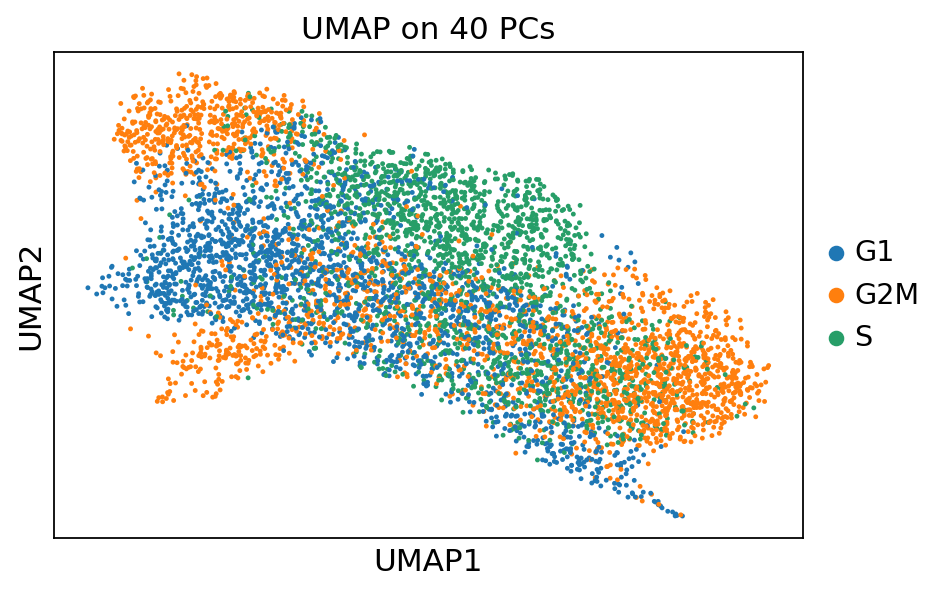

In [19]:
adata_cc_genes_regressed = adata[:, cell_cycle_genes]
print('After regressing out the cell cycle')

# PCA
sc.tl.pca(adata_cc_genes_regressed)
sc.pl.pca_scatter(adata_cc_genes_regressed, color='phase')

# UMAP on 40 PCs
sc.pp.neighbors(adata_cc_genes_regressed, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_cc_genes_regressed)
sc.pl.umap(adata_cc_genes_regressed, color='phase', title='UMAP on 40 PCs')

## Clustering the neighborhood graph using the Leiden graph-clustering method

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


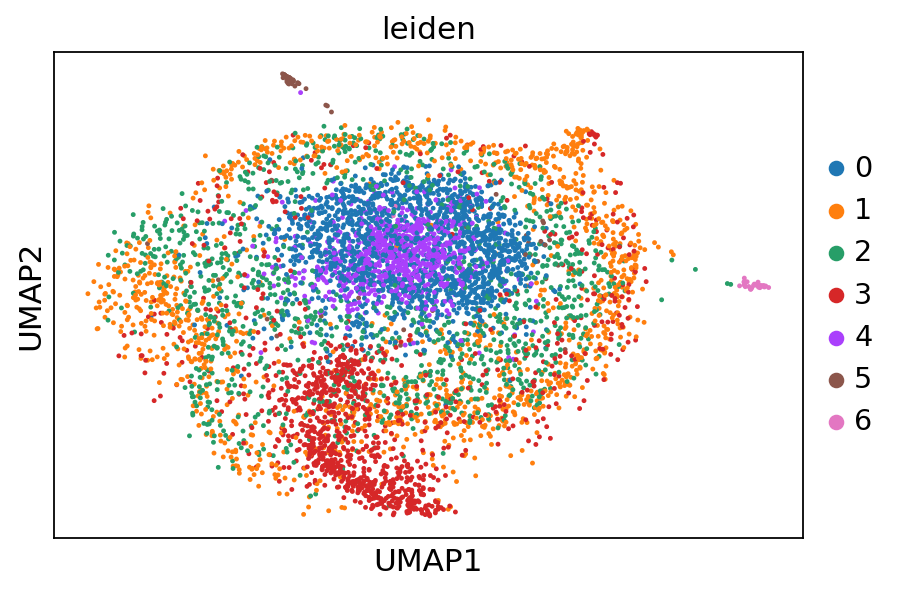

In [20]:
# Use all data X for clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=0)
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['leiden'], legend_loc='right margin')

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


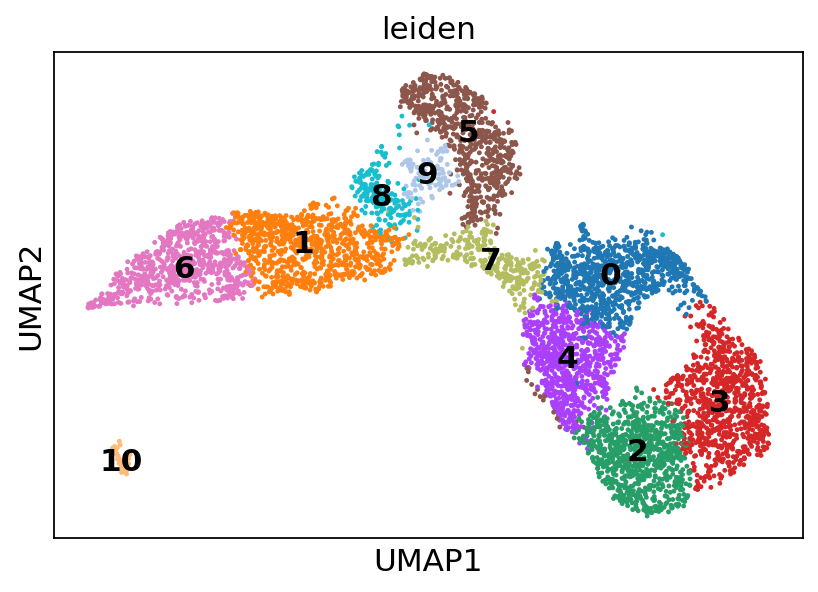

In [21]:
# Use only the first 40 PCs for clustering --> more distinct clusters
sc.pp.neighbors(adata, n_neighbors=70, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')

In [22]:
# Remove Cajal Retzius cells
if dataset == 'E14_hom':
#     cluster = '20'
    cluster = '7'
elif dataset == 'E13_hom':
    cluster = '10'
elif dataset == 'E13_het':
    cluster = '12'
elif dataset == 'E14_het':
    cluster = '19'

adata = adata[~adata.obs['leiden'].isin([cluster]),:]
# adata.raw = adata.copy()

In [23]:
adata.X.shape

(6222, 1722)

### Cell types

1. Neural progenitors: Pax6, Vim, Sox2
2. Intermediate progenitors: Eomes, Btg2,
3. Post-mitotic neurons: Tbr1, Sox5

Ectopic marker genes: 'Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3'

In [24]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

3 cell types:


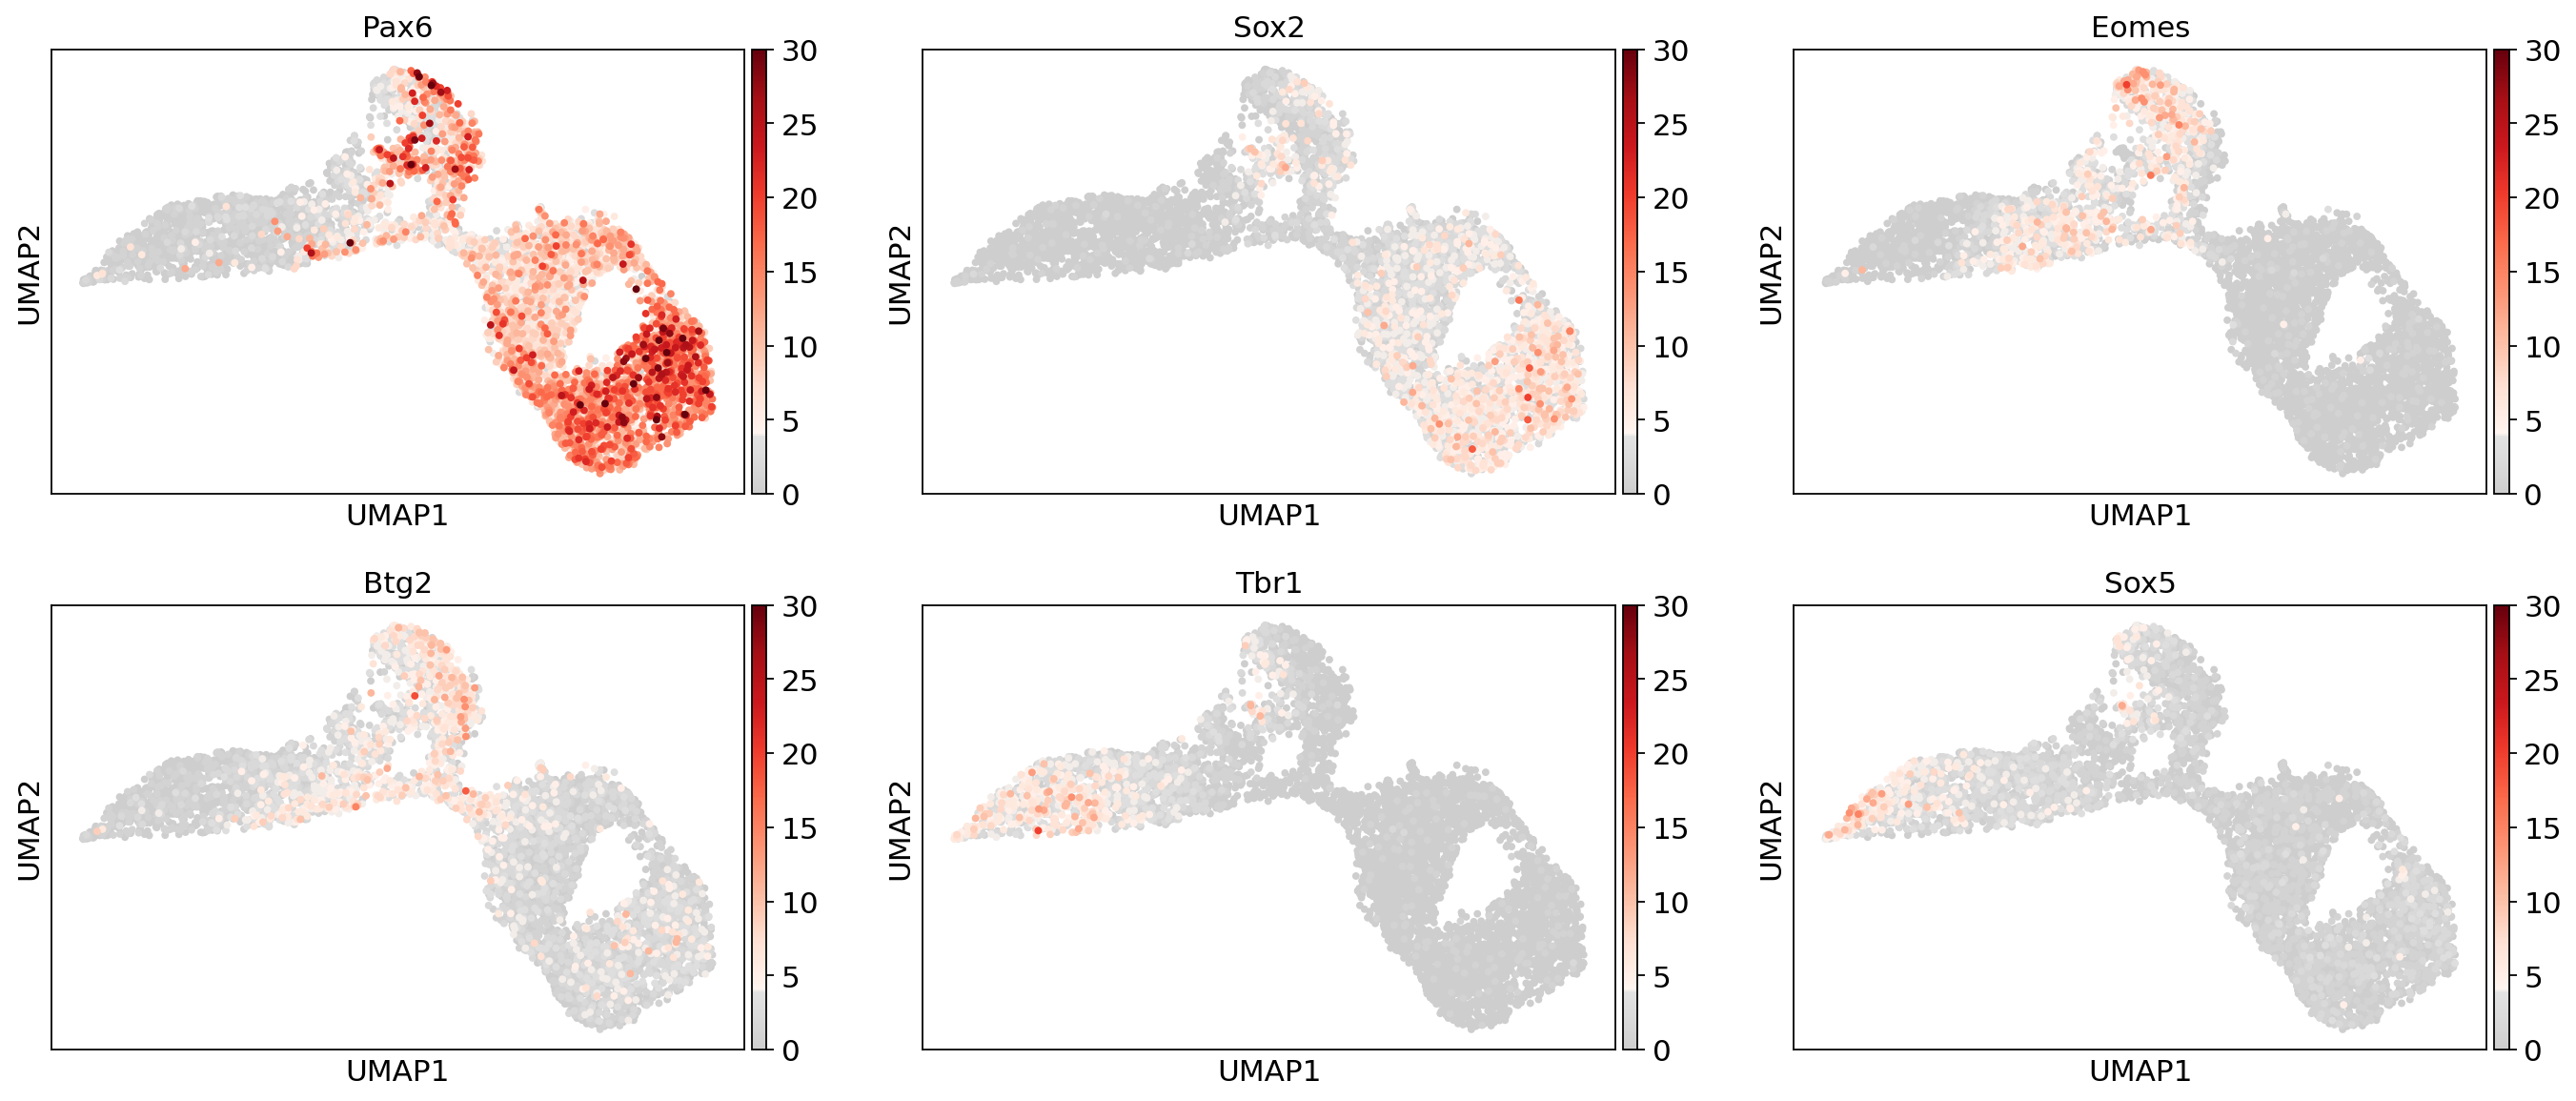

Ectopic:


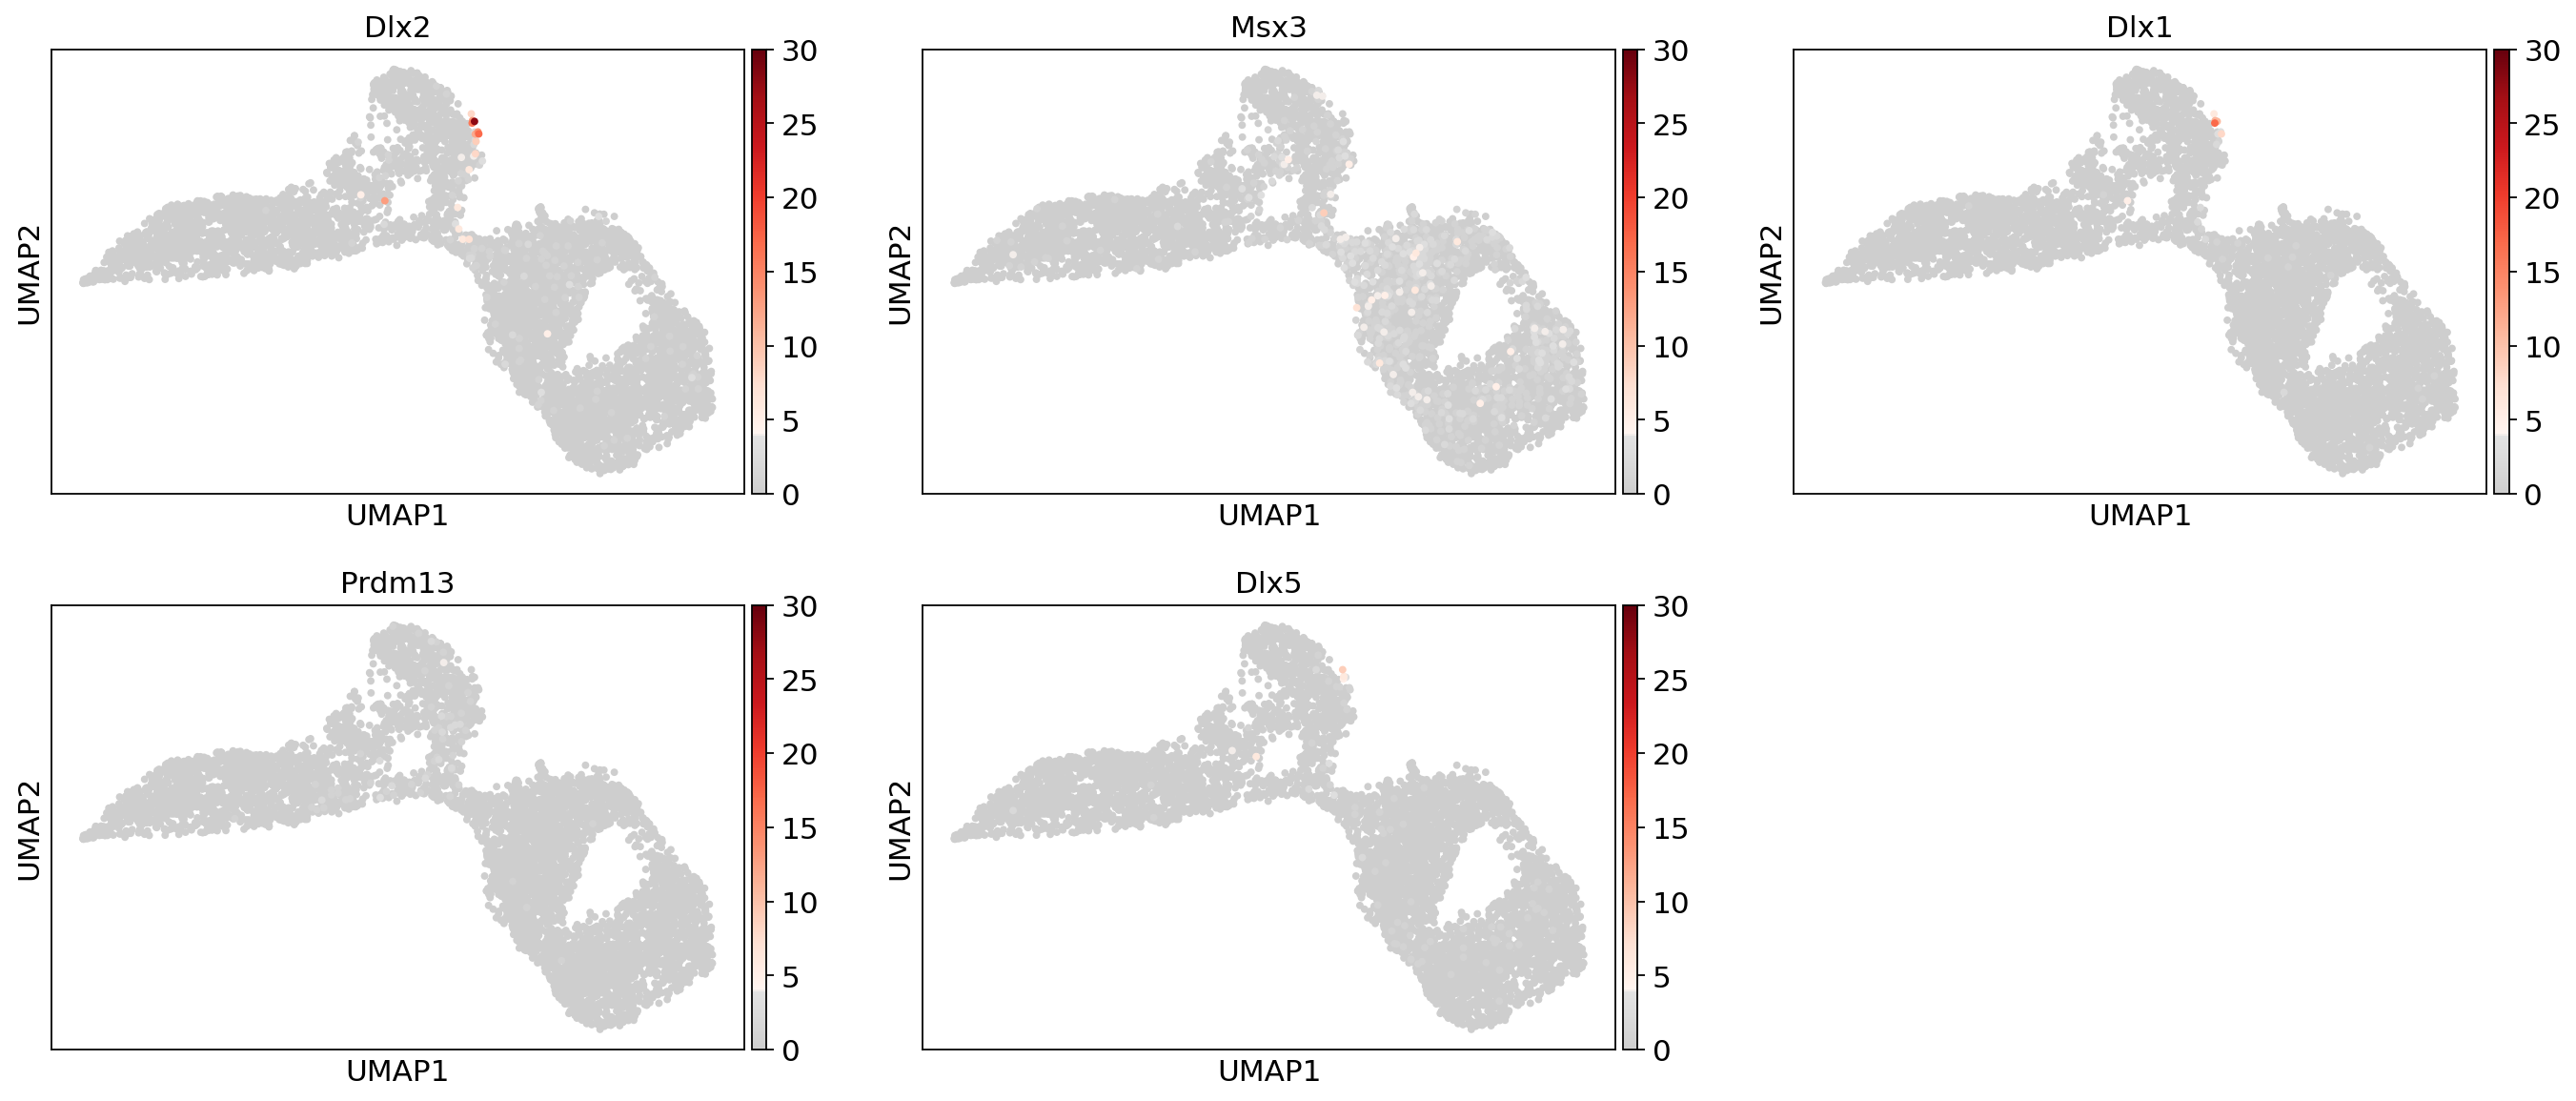

In [30]:
marker_genes = dict()
marker_genes['neural_progen'] = ['Pax6', 'Vim', 'Sox2'] if dataset == 'E14_hom' else ['Pax6', 'Sox2']
marker_genes['intermediate_progen'] = ['Eomes', 'Btg2']
marker_genes['post_mitotic'] = ['Tbr1', 'Sox5']
marker_genes['ectopic'] = ['Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3']

var_names = set(adata.var_names)
columns = set(adata.obs.columns)
gene_names = var_names.union(columns)
available_ectopic = gene_names.intersection(marker_genes['ectopic']) 

use_raw = True
vmin = 0
vmax = 30

cell_types = marker_genes['neural_progen'] + marker_genes['intermediate_progen'] + marker_genes['post_mitotic']
print('3 cell types:')
sc.pl.umap(adata, color=cell_types, cmap=mymap, legend_loc='on data',
           vmin=vmin, vmax=vmax,
           size=50, ncols=3,
           use_raw=use_raw)
           


print('Ectopic:')
sc.pl.umap(adata, color=available_ectopic, cmap=mymap,
           vmin=vmin, vmax=vmax,
           size=50, ncols=3,
           use_raw=use_raw)

### Visualise mean expression of each cell type

Trying to set attribute `.obs` of view, copying.


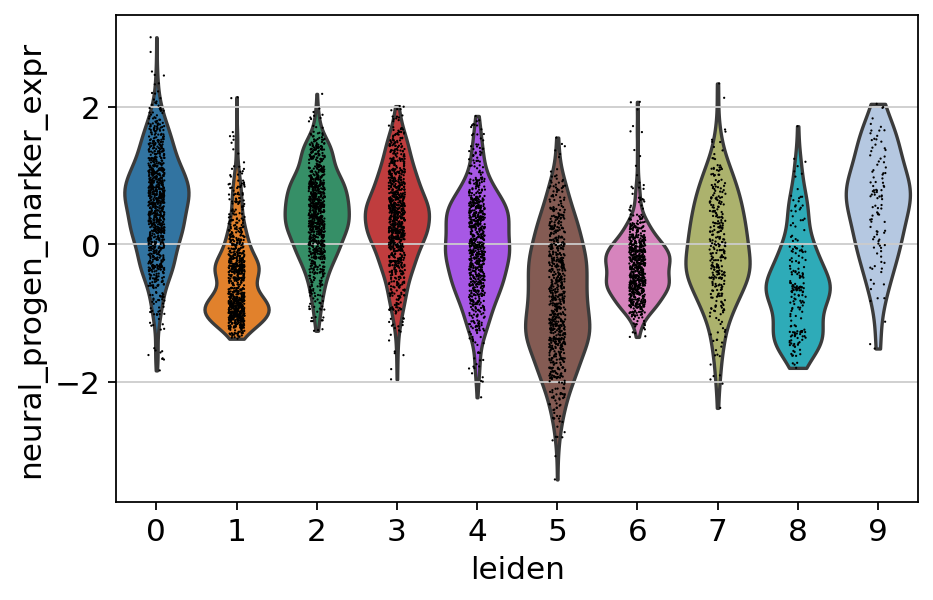

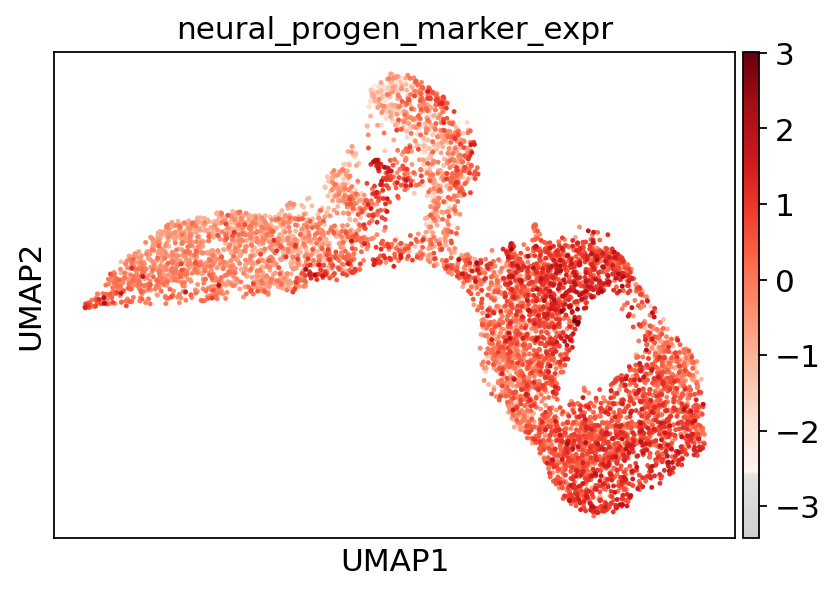

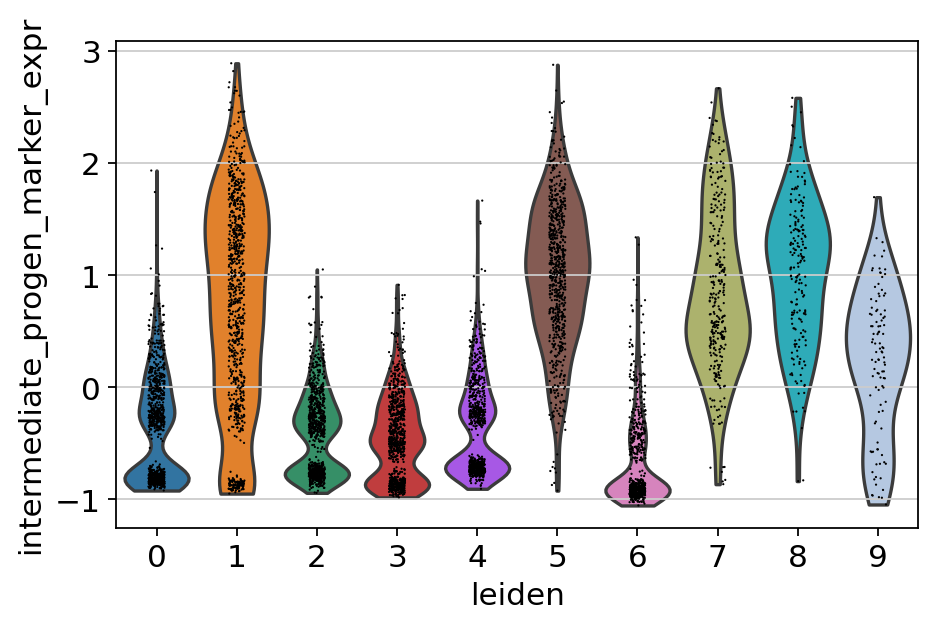

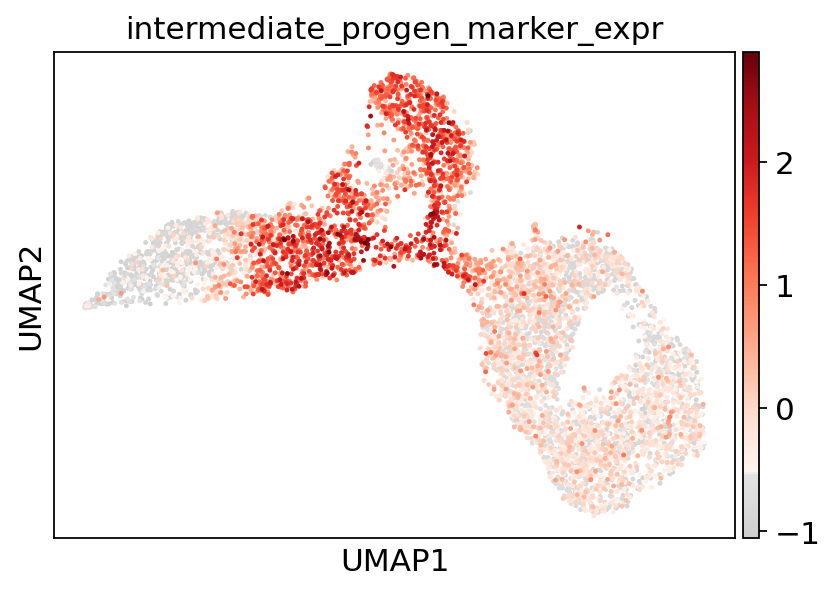

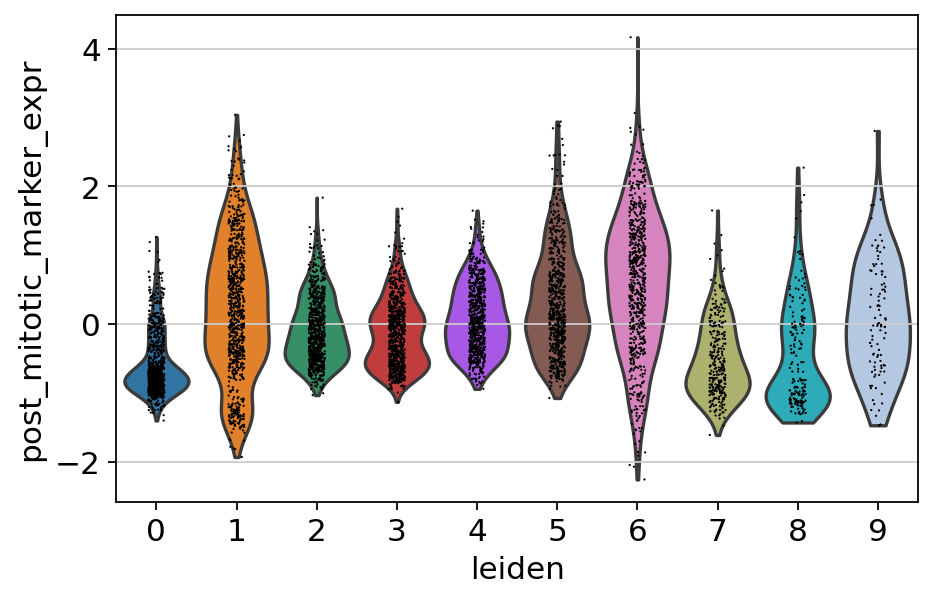

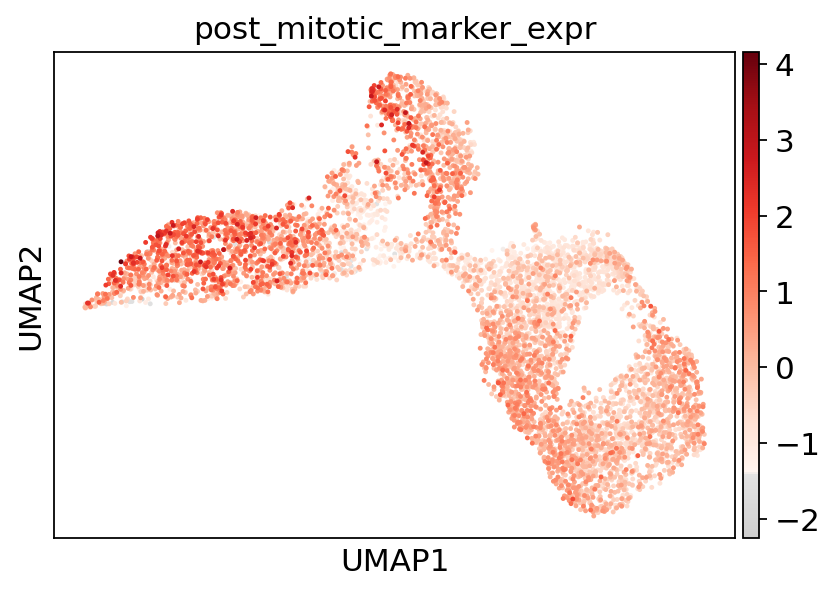

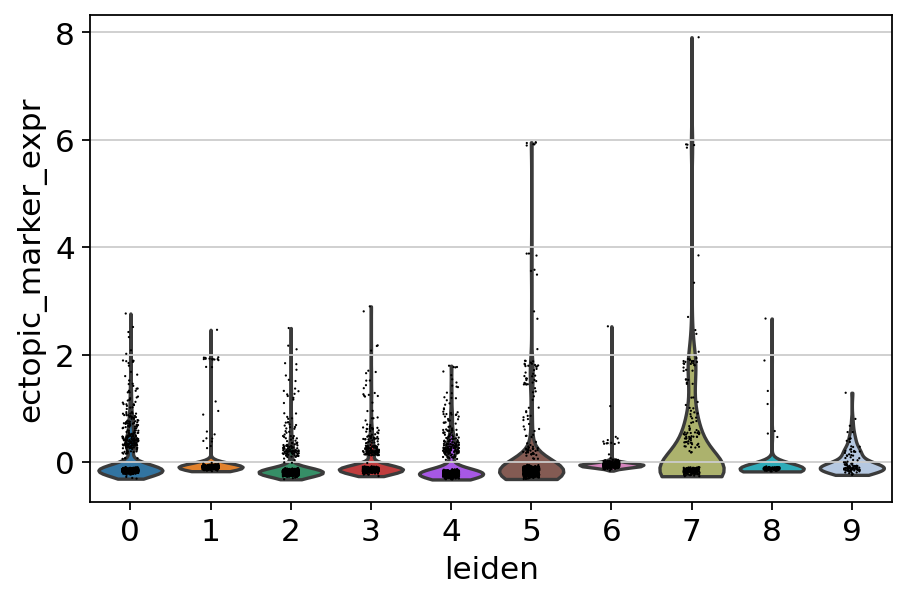

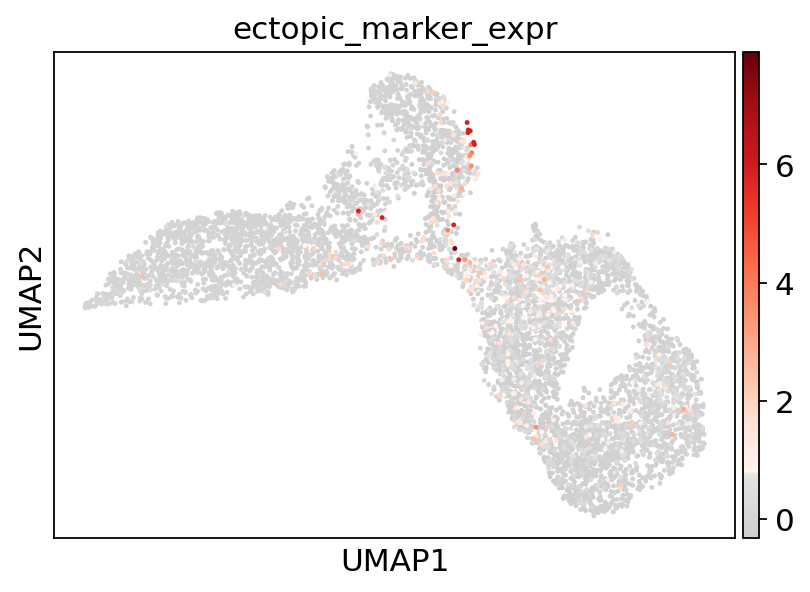

In [31]:
for cell_type in marker_genes.keys():
    cell_type_ids = np.isin(adata.var_names, marker_genes[cell_type])
    
    #Calculate the mean expression of the marker genes in each cell type
    obs_name = cell_type + '_marker_expr'
    adata.obs[obs_name] = adata.X[:, cell_type_ids].mean(1)
    
    #Plot enterocyte expression
    sc.pl.violin(adata, obs_name, groupby='leiden')
    sc.pl.umap(adata, color=obs_name, color_map=mymap)

Ectopic genes seem to be expressed mostly in clusters 1, 3, 5, 8

## Annotate clusters - not complete

In [34]:
# create a dictionary to map clusters to cell types
cluster2annotation = {
     '0': 'Intermediate Progenitors',
     '1': 'Ectopic',
     '2': 'Ectopic',
     '3': 'Intermediate Progenitors',
     '4': 'T-cell',
     '5': 'B-cell',
     '6': 'Monocytes',
     '7': 'Dendritic',
     '8': 'other',
     '9': 'B-cell',
     '10': 'other',
     '11': 'Dendritic'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
# pbmc.obs['cell type'] = pbmc.obs['clusters'].map(cluster2annotation).astype('category')

## More plots / statistics

### Dotplot

A dot is plotted for each gene and each cluster. Each dot represents two values: **mean expression within each cluster** (visualized by *color*) and **fraction of cells expressing the gene in the cluster** (visualized by the size of the *dot*).

/home/pts/dissertation_single_cell/.env/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:2920: RuntimeWarning: invalid value encountered in log1p
  matrix = np.log1p(matrix)


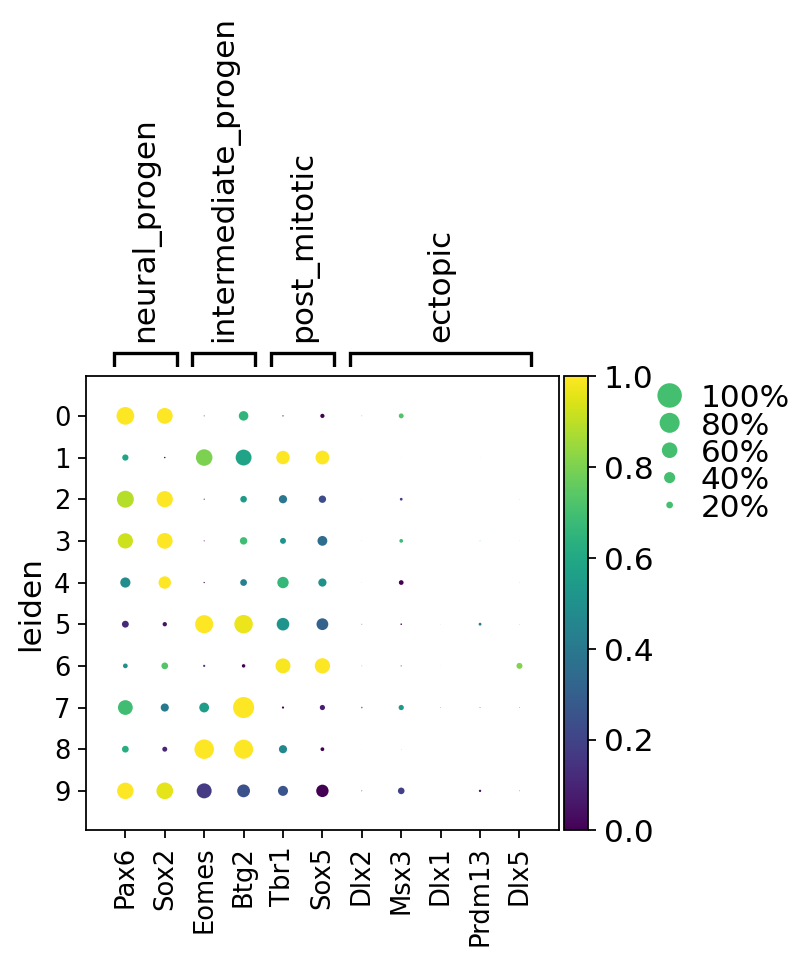

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[3.8499999999999996, 0, 0.2, 0.5, 0.25])

In [32]:
marker_genes['ectopic'] = available_ectopic
sc.pl.dotplot(adata, var_names=marker_genes, groupby='leiden', color_map='viridis', use_raw=False, log=True,
             standard_scale='group')

### Heatmap
Heatmap of the expression values of genes

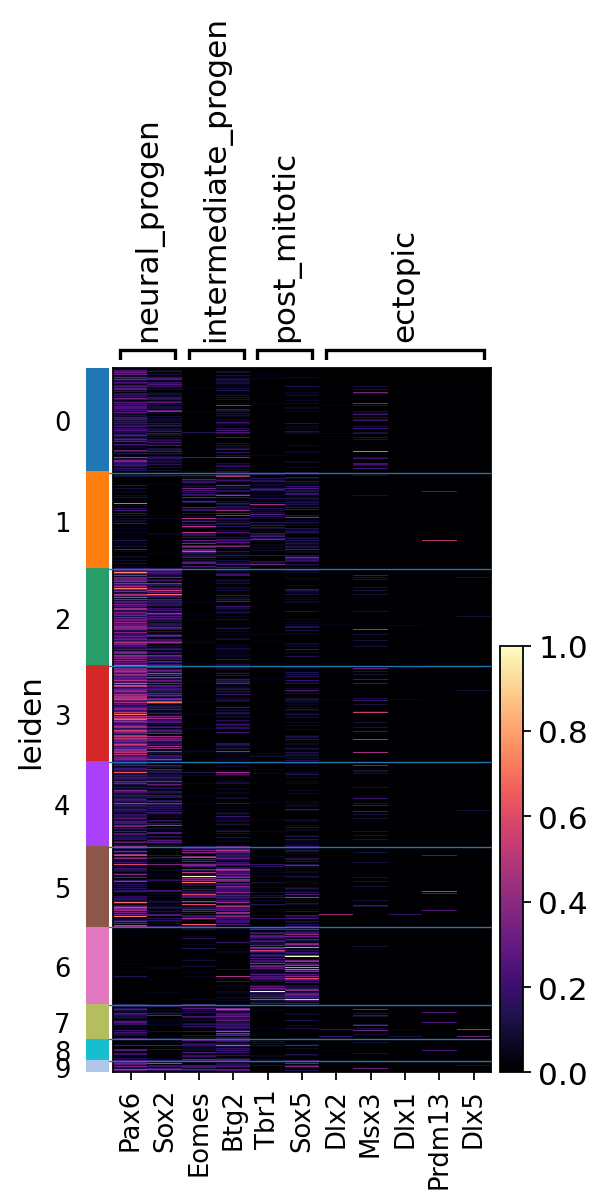

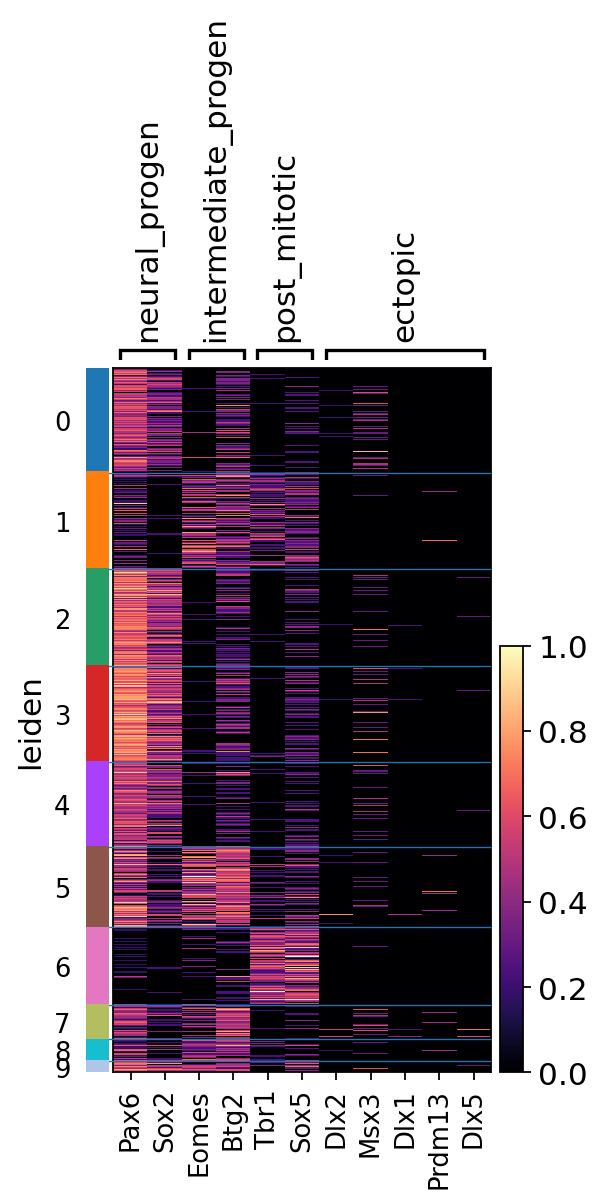

GridSpec(2, 4, height_ratios=[0.15, 6], width_ratios=[0.2, 3.3, 0, 0.2])

In [33]:
sc.pl.heatmap(adata, var_names=marker_genes, groupby='leiden', cmap='magma', standard_scale='var')
sc.pl.heatmap(adata, var_names=marker_genes, groupby='leiden', log=True, cmap='magma', standard_scale='var', swap_axes=False)

### Matrixplot
Creates a heatmap of the mean expression values per cluster of each gene

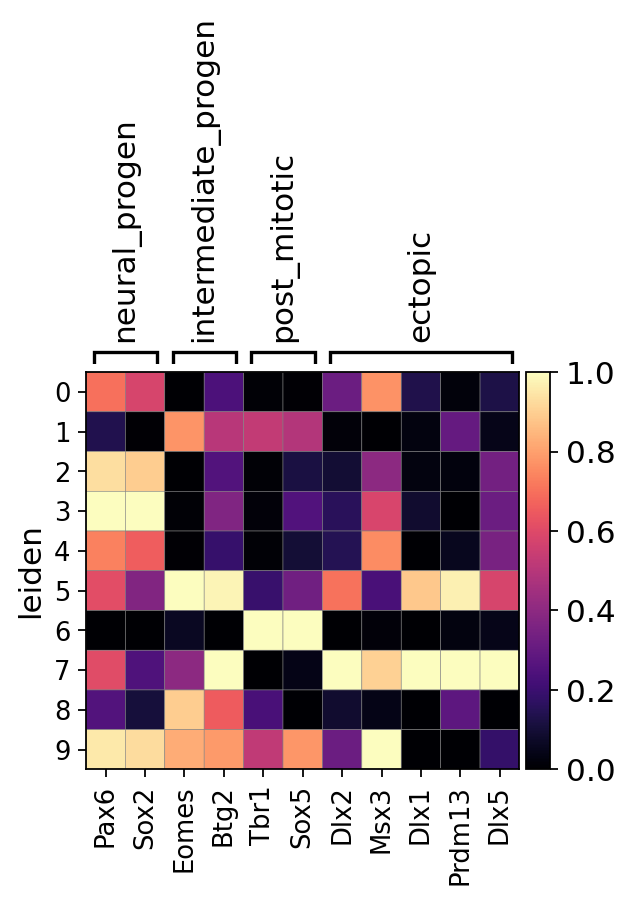

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[3.52, 0, 0.2])

In [34]:
sc.pl.matrixplot(adata, var_names=marker_genes, groupby='leiden',
                 cmap='magma', log=True, standard_scale='var')

## Write data to file

In [38]:
# print(adata.shape)
# # Write in h5ad file to use as an input to scDeepCluster
# adata_file = '../ann_data/exp_04/' + dataset + '_norm_variable_genes.h5ad'
# adata.write(adata_file)
# print('{} file saved'.format(adata_file))

In [35]:
print(adata.X.shape)
print(adata.raw.X.shape)

(6222, 1722)
(6222, 1722)


In [40]:
# print(adata)
# df = pd.DataFrame(adata.X)
# df.index = adata.obs_names
# df.columns = adata.var_names
# file = '../ann_data/' + dataset + '_no_cc.csv'

# df.to_csv(file)
# print('File {} created'.format(file))

## Some statistics - Incomplete

In [36]:
for i in marker_genes['ectopic']:
    print(i, adata.raw.var.n_cells[i])
    
print()

for i in cell_types:
    print(i, adata.raw.var.n_cells[i])
    
# print(adata.raw.var.n_cells['Gsx2'])

Dlx2 125
Msx3 789
Dlx1 30
Prdm13 59
Dlx5 76

Pax6 5145
Sox2 3819
Eomes 1880
Btg2 3994
Tbr1 1732
Sox5 2762
